# Importing data

In [8]:
#regex 
import re

#data manipulation:
import pandas as pd
import numpy as np

#nlp:
import nltk
import gensim

#language detection:
from langdetect import detect

# unidecode
import unidecode

# emoji support
import emoji

#spellchecker
from autocorrect import Speller

#tqdm for notebook progressbars
from tqdm.notebook import tqdm
tqdm.pandas() # pandas.progress_map & pandas.progress_apply 

# seeding numpy:
np.random.seed(2021)

<ipython-input-8-f14d4839f110>:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [9]:
"""
Topic modeling 
Tweets of the COVID_19
These tweets are collected using Twitter API and a Python script.
 A query for this high-frequency hashtag (#covid19) is run on a daily basis for a certain time period, to collect a larger number of tweets samples.
The tweets have #covid19 hashtag. Collection started on 25/7/2020, with an initial 17k batch.
"""
#Importing data
df = pd.read_csv(r"./data/covid19_tweets.csv", error_bad_lines=False)
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


# Checking for undesirable rows :

In [10]:
# csv exploration showed that we have no retweets :
print("Number of rows in the df :", df.shape[0])
print("Number of retweets :", df[df["is_retweet"] == True].shape[0])
print("List of all possible values in 'is_retweet' :",df.is_retweet.unique())

# we can safely drop the is_retweet column :
df.drop('is_retweet',axis=1, inplace=True)

Number of rows in the df : 179108
Number of retweets : 0
List of all possible values in 'is_retweet' : [False]


In [11]:
# since we are not supposed to have retweets, identical tweets are probably spam/bots !
# counting identical tweets :
print("Total number of rows in the df :", df.shape[0])
print("Nbr of identical tweets :", df.shape[0] - len(df.value_counts('text')))

# dropping identical tweets:
df.drop_duplicates('text', inplace=True)
print("Remaining rows after dropping the duplicates :", df.shape[0])

Total number of rows in the df : 179108
Nbr of identical tweets : 425
Remaining rows after dropping the duplicates : 178683


In [12]:
# checking if we have rows with nothing in the tweet body:
print("Number of rows with no tweet body :", len(df[df.text.isna()])) #ok

Number of rows with no tweet body : 0


# Processing the tweets :

In [22]:
# regex patterns:
url_pattern = re.compile(r'https?://\S+|www\.\S+')
number_pattern = re.compile(r'\d+')
specialchar_pattern = re.compile(r'[^\w\s]')
multiplespaces_pattern = re.compile(r'\s\s+')

def preprocessor(text):
    #replace emojis with text :
    text = emoji.demojize(text, delimiters=(" ", " "))
    
    #remove all unicode funk:
    text = unidecode.unidecode(text)
    
    #remove caps:
    text = text.lower()
    
    #remove urls :
    text = re.sub(pattern=url_pattern, repl='', string=text)
    
    #remove numbers :
    text = re.sub(pattern=number_pattern, repl='', string=text)
    
    #remove special chars :
    text = re.sub(pattern=specialchar_pattern, repl='', string=text)
    
    #remove the '\n' probably created by unidecode and the remaining "_"
    text = text.replace("\n", " ").replace("_", " ")
    
    #merge multiple spaces into 1:
    text = re.sub(pattern=multiplespaces_pattern, repl=' ', string=text)
    
    return(text)

In [23]:
df["c_text"] = df.text.progress_map(preprocessor)

  0%|          | 0/178683 [00:00<?, ?it/s]

In [24]:
df.head(5)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,c_text,lang
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,if i smelled the scent of hand sanitizers toda...,en
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,hey yankees yankeespr and mlb wouldnt it have ...,en
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,diane wdunlap realdonaldtrump trump never once...,en
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,brookbanktv the one gift covid has give me is ...,en
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,july media bulletin on novel coronavirusupdat...,en


# Checking the tweets after processing :

In [25]:
# It's likely that the preprocessor fnc completely deleted some tweets.
# Count the lines and remove them.
# also remove all-whitespace tweets & single letter tweets :
print("Number of empty tweets after preprocess :", df.shape[0] -df[df['c_text'].apply(
    lambda x: len(str(x).replace(" ","")) > 1)].shape[0])
# this is surprising!

# just in case, checking min and avg tweet len():
print("Minimum tweet len() :", df.c_text.str.len().min())
print("Mean tweet len() :", df.c_text.str.len().mean())
# I was wrong, no need to remove anything !

Number of empty tweets after preprocess : 0
Minimum tweet len() : 10
Mean tweet len() : 100.6656369100586


# Tweet language detection:

In [26]:
#use langdetect to detect the lang of every tweet in the df:
# this is pretty slow (~10 min @~320it/s)
df["lang"] = df.c_text.progress_map(detect)

  0%|          | 0/178683 [00:00<?, ?it/s]

In [27]:
# pickle the results:
import pickle as pk
with open("./tweet_df.pk", "wb") as fp:
    pk.dump(df, fp)
#the file is ~75mo

In [28]:
# Number of tweets that are probably not in english:
print("Nbr of non-english tweets :", df[df["lang"]!="en"].shape[0])

# 10 most detected tweet languages:
print("\n10 most detected languages :\n",df.lang.value_counts()[:10], end="")

Nbr of non-english tweets : 2461

10 most detected languages :
 en    176222
it       526
es       324
id       244
ca       209
ro       175
fr       175
et       124
nl       115
da       100
Name: lang, dtype: int64

In [29]:
# dump the non-english tweets in a file for manual exploration :
with open("./noneng.csv", "w", encoding="utf8") as fp:
    [fp.write(f"{elem}\n\n") for elem in df[df["lang"]!="en"].c_text]

In [30]:
#after manually reviewing the tweets tagged as non-english, 
#I'm ok with removing them from the dataframe:
df.drop(df[df["lang"] != "en"].index, inplace = True)
#most of the time they contain gibberish
#it's only ~2.5K out of 178K
print("Remaining tweets :",df.lang.value_counts())

Remaining tweets : en    176222
Name: lang, dtype: int64


# Using spaCy to tokenize & tag the tweets :

spaCy is an open source python lib for NLP.  
It has tons of features. It's 100% overkill to use it for this assignement.  
<br/>
I'm going to use it to :
- Tokenize the preprocessed tweets
- Assign part-of-speech tags to the tokens
- Detect and label named entities in the tokens
- Lemmatize the tokens using their part-of-speech tags  

<br/>
Lemminflect is a dedicated lemmatizer compatible with spacy that is supposed to be even more accurate

In [71]:
# tokenize, remove stopwords and lemmatize everything
# using a dedicated spacy pipeline :
import spacy
import lemminflect

# load the desired pretrained spacy model:
# https://spacy.io/models/en
nlp = spacy.load('en_core_web_sm') #this is the faster & less-accurate model

df["doc"]= df.c_text.progress_map(nlp)

# pickle the results asap:
import pickle as pk
with open("./tweet_df_wdocs_sm.pk", "wb") as fp:
    pk.dump(df, fp) # ~1.7gigs

  0%|          | 0/176222 [00:00<?, ?it/s]

In [ ]:
# this is the same thing as before with a bigger, state of the art model
import spacy
import lemminflect

nlp = spacy.load('en_core_web_trf') # load the big boy:

#takes hours since my gpu is not detected:
df["doc"]= df.c_text.progress_map(nlp) 

# pickle the results:
import pickle as pk
with open("./tweet_df_wdocs_trf.pk", "wb") as fp:
    pk.dump(df, fp)

  0%|          | 0/176222 [00:00<?, ?it/s]

After execution, spaCy models create "docs". Docs are token containers.   
Every token has attributes :  
https://spacy.io/api/token#attributes  
<br/>
Some attributes can be used to select wich words we are going to feed the nlp model with:
- is_ascii and is_alpha : to select only text tokens (this is a bit redundant with the preprocessing)
- pos_ : Coarse-grained part-of-speech tag from https://universaldependencies.org/docs/u/pos/.
- tag_ : Fine-grained part-of-speech.
- lang_ : Language of the parent document’s vocabulary.
- is_stop: Boolean if the token is part of a stoplist
- ._.lemma(): token after lemmatization with lemminflect


In [108]:
# doc attrib exemples :
print(df.iloc[665].doc, '\n')
[print(f"{tok} : {tok.pos_=} | {tok.is_stop=} | {tok.is_alpha=} | {tok._.lemma()=}") 
 for tok in df.iloc[6555].doc]

new covid preprint decreased incidence virus transmission capacity and severity of covid at altitude on th  

breakingbad : tok.pos_='ADJ' | tok.is_stop=False | tok.is_alpha=True | tok._.lemma()='breakingbad'
chief : tok.pos_='ADJ' | tok.is_stop=False | tok.is_alpha=True | tok._.lemma()='chief'
minister : tok.pos_='NOUN' | tok.is_stop=False | tok.is_alpha=True | tok._.lemma()='minister'
of : tok.pos_='ADP' | tok.is_stop=True | tok.is_alpha=True | tok._.lemma()='of'
madhya : tok.pos_='NOUN' | tok.is_stop=False | tok.is_alpha=True | tok._.lemma()='madhya'
pradesh : tok.pos_='NOUN' | tok.is_stop=False | tok.is_alpha=True | tok._.lemma()='pradesh'
chouhanshivraj : tok.pos_='VERB' | tok.is_stop=False | tok.is_alpha=True | tok._.lemma()='chouhanshivra'
tests : tok.pos_='NOUN' | tok.is_stop=False | tok.is_alpha=True | tok._.lemma()='test'
positive : tok.pos_='ADJ' | tok.is_stop=False | tok.is_alpha=True | tok._.lemma()='positive'
for : tok.pos_='ADP' | tok.is_stop=True | tok.is_alpha=True | t

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [138]:
# create a function to filter words with their atrributes:
def selectwords(doc):
    word_list = []
    for tok in doc:
        if (tok.is_alpha):
            if not (tok.is_stop):
                if (len(tok) > 2):
                    if (tok.pos_ in ["NOUN", "VERB", "ADJ", "PROPN"]):
                        word_list.append(tok._.lemma())
    
    if (len(word_list) > 0):
        return(word_list)

processed_docs = df.doc.progress_map(selectwords)

H:\Programmes\Ancaconda\envs\fdd\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/176222 [00:00<?, ?it/s]

In [123]:
# creating a gensim dict:
dictionary = gensim.corpora.Dictionary(processed_docs)


In [145]:
# Gensim filters
# filters out tokens that appear in :
# less than X documents (absolute number)
# more than Y documents (fraction of total corpus size, not absolute number)
# after the above two steps, keep only the first Z most frequent tokens
X=30
Y=0.6
Z=100000
dictionary.filter_extremes(no_below=X, no_above=Y, keep_n=Z)

In [147]:
# For each document we create a dictionary reporting how many
# words and how many times those words appear :
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

tfidf = gensim.models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# define LDA model using the TF-IDF dictionary
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf,
                                             num_topics=6,
                                             id2word=dictionary,
                                             passes=3,
                                             workers=3)

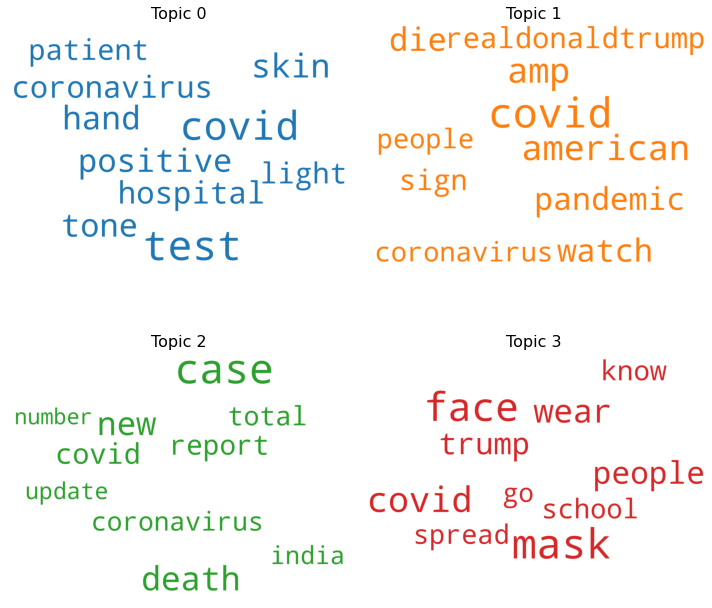

In [150]:
# Wordcloud of Top N words in each topic
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

custom_stop = ["https", "co", "RT", "amp", "go"]

cloud = WordCloud(stopwords= custom_stop + list(STOPWORDS),
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_tfidf.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [142]:
#visualize with pyLDAvis
import warnings
# pyLDAvis is creating warnings everywhere....
warnings.filterwarnings("ignore") 

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary=lda_model_tfidf.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.117361 -0.071603       1        1  21.318084
4      0.128710  0.150763       2        1  18.440778
3      0.079781  0.000997       3        1  16.323369
0     -0.340529  0.033285       4        1  15.645870
5      0.003037 -0.182941       5        1  14.238948
1      0.011641  0.069498       6        1  14.032952, topic_info=           Term         Freq        Total Category  logprob  loglift
57         case  3678.000000  3678.000000  Default  30.0000  30.0000
32        death  2451.000000  2451.000000  Default  29.0000  29.0000
174       total  1299.000000  1299.000000  Default  28.0000  28.0000
193      report  1627.000000  1627.000000  Default  27.0000  27.0000
220         new  2813.000000  2813.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
220         new   221.963406  2813.645234   Topic6  -5.6267  -0.5760
80   government   171.623241   778.784386   Topic6  -5.8839   0.4513
437          go   158.094431   955.869099   Topic6  -5.9660   0.1643
269       world   157.118475  1064.293307   Topic6  -5.9722   0.0507
202         say   155.432027  1146.234724   Topic6  -5.9830  -0.0343

[474 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
3522      3  0.997115     abo
955       4  0.999111  active
553       1  0.987677  affair
471       1  0.629103  affect
471       2  0.047705  affect
...     ...       ...     ...
180       2  0.202506    year
180       3  0.140284    year
180       4  0.018101    year
180       5  0.228527    year
180       6  0.132365    year

[1160 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 1, 6, 2])